# Notebook for testing flyD function and developping new implementations.

working_functions.py stores the "finished" functions.
Things to implement in it :
    -more metadata ?

method the object should have :
    -output the object seen by the fly at a given time based on all the other fly object in the "session" (or just given a number of fly objects)

In [2]:
    ### Necessary modules

#for plots
import matplotlib.pyplot as plt
import operator


# trajectorytools needs to be installed. To installed follow the instructions 
# at http://www.github.com/fjhheras/trajectorytools
from trajectorytools.constants import dir_of_data
import trajectorytools as tt
import trajectorytools.plot as ttplot
import matplotlib.patches as mpatches
import trajectorytools.socialcontext as ttsocial
import copy
from scipy import stats
import numpy as np
import cv2
import skvideo.io
import imutils
import numpy.ma as ma
import scipy.signal as sgl


from matplotlib.axes import Axes as ax

#My functions
import working_functions as flyD
#import graphing_data #Not useful at the moment

#For importing files and timing cells.
import time
import matplotlib.mlab as mlab

Analysis function based on numerous fly_data objects from a single video :

    -position_summary: summarizes where we can find other flies relatively to our focus fly

    -A focus fly should be defined
    -Relative_fly object should be calculates based on the focus fly
    -What to calculate of this ?
    -Correlation between "turning" of the fly (derivation of orientation) and position of other flies ("global" position and specific position of every fly)

Landscape function ?:
    -Given a focus fly and a set of object, single-object projection of everything the fly sees ? 

# Cell below doesn't need to be executed, is just here to write down data so it's possible to pick it up quickly afterward (get_ori takes ~6min to run)

In [2]:
flyD.save_ori_pickle("t4t5")
flyD.save_ori_pickle("fly2")
flyD.save_ori_pickle("3flies")
flyD.save_ori_pickle("6flies_1")
flyD.save_ori_pickle("6flies_2")

/home/maubry/python/idtrackerai/working_functions.py:344: RuntimeWarning: divide by zero encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))
/home/maubry/python/idtrackerai/working_functions.py:344: RuntimeWarning: invalid value encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))
/home/maubry/python/idtrackerai/working_functions.py:68: RuntimeWarning: invalid value encountered in greater
  crop_dir[dir_var>0.1] = np.nan


time elapsed : 8.0min and 9sec
time elapsed : 2.0min and 12sec
time elapsed : 6.0min and 57sec
time elapsed : 1017.0min and 50sec
time elapsed : 8.0min and 2sec


# Simple demonstration of the landscape function, with plotting of the result.

/home/maubry/python/idtrackerai/working_functions.py:121: RuntimeWarning: invalid value encountered in less
  angle[angle < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:124: RuntimeWarning: invalid value encountered in less
  ori_rel[ori_rel < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:344: RuntimeWarning: divide by zero encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))
/home/maubry/python/idtrackerai/working_functions.py:344: RuntimeWarning: invalid value encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))
/home/maubry/python/idtrackerai/working_functions.py:378: RuntimeWarning: divide by zero encountered in double_scalars
  fly.size[i] = fly.size[i]*(projection_distance/fly.dist[i])
/home/maubry/python/idtrackerai/working_functions.py:378: RuntimeWarning: invalid value encountered in double_scalars
  fly.size[i] = fly.size[i]*(projection_distance/fly.dist[i])


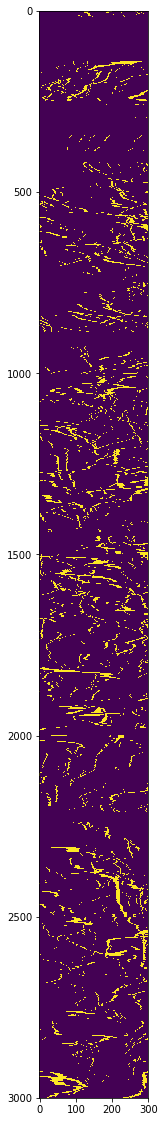

<Figure size 1440x360 with 0 Axes>

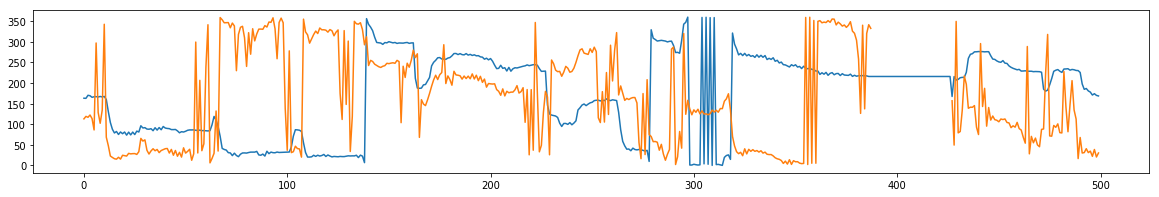

In [6]:
#Defining landscape function.
#For a specific fly, should output what the fly sees as stimilus for every frames.

    #Convert everything into a simple matrix of occupied pixels
    
stack = flyD.get_ori_pickle('t4t5')

identity = 5
hue = flyD.landscape(stack, identity)

#fig, ax_meanposmap = plt.subplots(figsize=(200,20))
#ax_meanposmap.imshow(X=hue[:1000,])

time_range = range(3000)

hue_trans = np.transpose(hue)
fig, ax_meanposmap = plt.subplots(figsize=(200,20))
ax_meanposmap.imshow(X=hue[time_range,:])
plt.savefig("vision.png")
plt.figure(figsize=(20,5))

plt.figure(figsize=(20,3))
#plt.plot(fly_correc.orientations)
plt.plot(stack[identity].orientations[500:1000])
plt.plot(stack[identity].directions[500:1000])

Writes a video focusing on a single fly. Video currently set up to demonstrate how and under which conditions direction can be useful

Probably not useful enough to be made into a function. Should be kept nonetheless just in case.

In [141]:
path_to_vid = "raw/6flies_1.avi"

flystack = flyD.get_ori_pickle('6flies_1')
focus = flystack[2]

thresh=100

cap = cv2.VideoCapture(path_to_vid)
framerate=30
fps=str(framerate)
inputdict={'-r': fps}
outputdict={'-vcodec': 'libx264', '-pix_fmt': 'yuv420p', '-r': fps}
font = cv2.FONT_HERSHEY_SIMPLEX
output_name = "solofly3.avi"
writer = skvideo.io.FFmpegWriter(output_name, inputdict, outputdict)

p = 40
take_from = 2200
cap.set(1,take_from)
# for i in range(take_from):
#     ret, img = cap.read()
    
for i in range(120):
    center = focus.positions[int(i+take_from)]
    center = center.astype('int')

    ret, img = cap.read()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img = img[int(center[1]-p):int(center[1]+p), 
                   int(center[0]-p):int(center[0]+p)]
    
    
    ret, diff_img = cv2.threshold(img,thresh,255,cv2.THRESH_BINARY) #Sets the video to binary according to thresh
    contours,hierarchy = cv2.findContours(diff_img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    
    try:
        ellipse = cv2.fitEllipse(contours[0]) #Fitting the ellipse
    except:
        ellipse = cv2.fitEllipse(contours[1]) #Fitting the ellipse
        
    cv2.ellipse(img,ellipse,(0,0,255))

        
    angle = np.radians(ellipse[2]-90)

    newx = 40+(np.cos(angle)*20) #Get distance forward in x
    newy = 40+(np.sin(angle)*20) #Get distance forward in y
            
    center_plus = (int(newx),int(newy)) #Second point of vector
            
    center = tuple(center) #Conversion to please cv2
    center_plus = tuple(center_plus)
    
    
    cv2.line(img, (40,40), center_plus, (255,0,0)) #Draw line

    
    
    
    
    writer.writeFrame(img)
    
writer.close() 

# Comparing corrected orientation and directions

[       nan        nan 0.3531811  ... 0.0453452  0.18758658 0.13248137]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


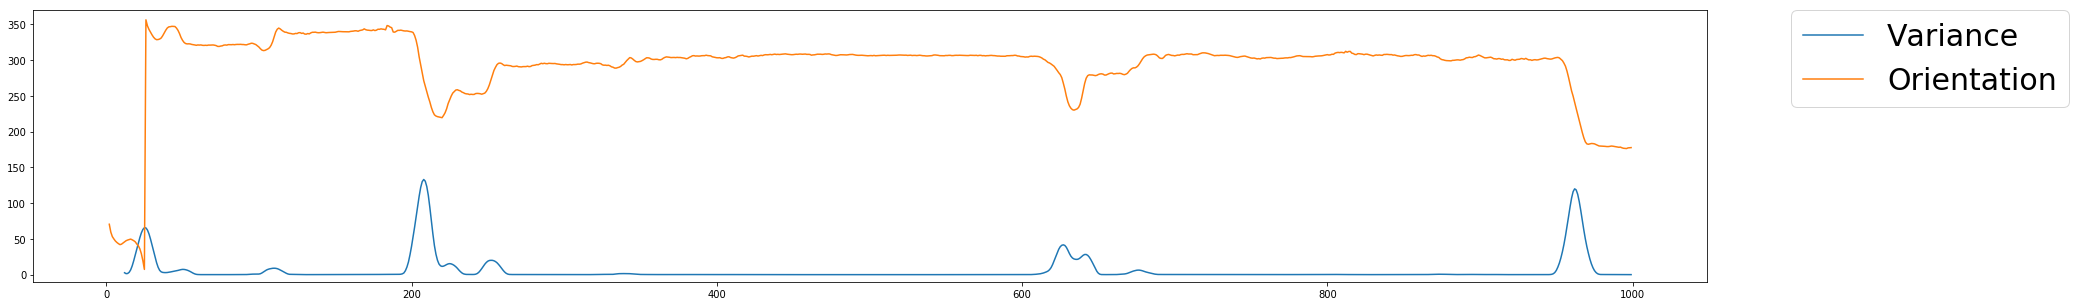

In [72]:
#Get the data and select a focus fly

flystack = flyD.get_ori_pickle("6flies_1")
fly = flystack[1]

#Get only the good parts of fly.directions
crop_dir = copy.deepcopy(fly.directions)
mean = flyD.rolling_stat(stats.circmean,2)(np.radians(fly.orientations[:1000]))
ori_var = flyD.rolling_stat(stats.circvar,10)(mean)
print(dir_var)
crop_dir[dir_var>0.100] = np.nan

#get the orientations just corrected for the right referential
correc = flyD.convertToTrigo(fly.old_ori, reverse=False)

#Compare directions, just corrected for the right referential, and orientations checked for matching with directions
plt.figure(figsize=(30,5))
plt.ylim(-10,370)
# plt.plot(crop_dir)
plt.plot(ori_var*200, label="Variance")

plt.plot(np.degrees(mean), label="Orientation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 30})

plt.savefig("angle.png")
plt.show()


# flyD.draw_ori("raw/6flies_2.avi", flystack,output_name="6flies_2_drawori.avi", corrected = True)

## Correlation between landscape and behaviour 

We want to find correlations between behaviour at time T (e.g. turning left) to previous landscape (e.g. last 30 frames).
How to avoid correlation betwee past behaviour and current behaviour ? 
    -Need moment when behaviour *begins* to avoid inertia effect.

In [ ]:
flystack = flyD.get_ori_pickle("6flies_1")
n_flies = len(flystack)
tot_peaks = 0




time = 30 #time to take before peak

preturn_sum = np.zeros([time,300])
control_sum = np.zeros([time,300])

rolling_circmean = flyD.rolling_stat(stats.circmean, 3)
rolling_circvar = flyD.rolling_stat(stats.circvar,10)


plt.figure(figsize=(20,5))
plt.ylim(0,np.pi*2)
plt.plot(np.radians(flystack[1].orientations[:3000]))
plt.plot(rolling_circvar(np.radians(flystack[1].orientations[:3000])))*10

v = 1
for i in range(n_flies):
    identity = i
    fly = flystack[identity]
    time_range = range(36000)
    ori = fly.orientations[time_range]
    
    #Calculate peaks for right turning and left turning
    peaks = flyD.orientation_peaks(ori, peak_height=0.005)
    if i ==1:
        plt.plot(peaks[0], np.zeros_like(peaks[0]), ".", markersize=10)

    n_peaks = len(peaks[0])
    vision = flyD.landscape(flystack, identity) #Compute the flyvision matrix
    vision = vision[time_range,:]
    
    
    #Take what you want as control
    not_turning = ori_var < 0.01
    not_turning_vision = vision[time_range,:]
    not_turning_sum = np.sum(vision, axis = 0)
    
    control_sum += not_turning_sum

    
    #Add right peaks
    peak_beg = np.zeros_like(peaks[0])
    peak_beg = peaks[0] - peaks[1]['widths']
    
    for i in range(n_peaks):
        beg = peak_beg[i]
        if beg < time:
            continue

        preturn_chunk = vision[int(beg-time):int(beg),:]
        preturn_sum += preturn_chunk
    tot_peaks += n_peaks
    
print(tot_peaks)
#Normalisation of preturn vision :
#We divide every point by the number of peaks
#This gives a probability that the place is filled (from 0 to 1)

preturn_norm = preturn_sum/tot_peaks


# Other normalisation, though this one is doubtful :
preturn_summary = stats.describe(preturn_sum)
preturn_mean = np.mean(preturn_summary.mean)
norm_preturn_sum = preturn_sum[:,:]/preturn_mean
control_norm = control_sum/np.mean(control_sum)

#Plot frequency of fly positions
plt.figure(figsize=(20,5))
plt.imshow(preturn_norm, cmap='jet', interpolation='nearest')
plt.colorbar()

for i in range(preturn_norm.shape[1]):
    preturn_norm[:,i] = preturn_norm[:,i]/np.mean(preturn_norm[:,i]) 

plt.figure(figsize=(20,5))
plt.imshow(preturn_norm, cmap='jet', interpolation='nearest')
plt.colorbar()

plt.figure(figsize=(20,5))
plt.imshow(control_sum, cmap='jet', interpolation='nearest')
plt.colorbar()



/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


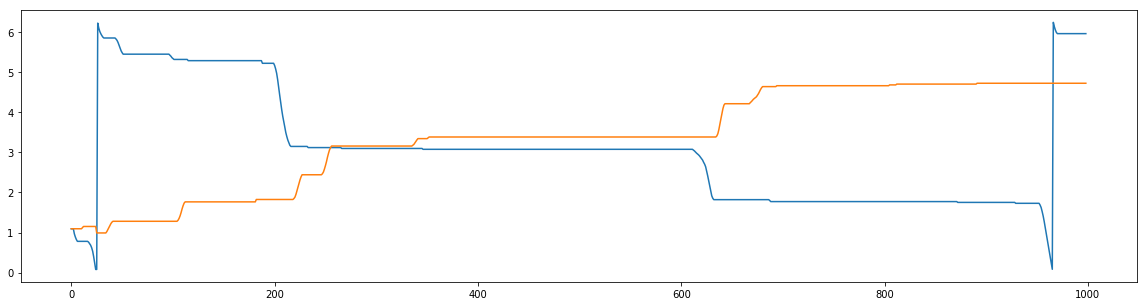

In [154]:
flystack = flyD.get_ori_pickle('6flies_1')
fly = flystack[1]

rolling_mean= flyD.rolling_stat(stats.circmean, 3)

ori_mean = rolling_mean(np.radians(fly.orientations[:1000]))

diff_left = np.diff(ori_mean)
diff_right = np.diff(ori_mean)

diff_right[diff_right < 0.02 ] = 0
diff_left[diff_left > -0.02 ] = 0

diff_left[np.isnan(diff_left)] = 0
diff_right[np.isnan(diff_right)] = 0

hue1 = np.cumsum(diff_left)
hue2 = np.cumsum(diff_right)

hue1 +=ori_mean[3]
hue2 +=ori_mean[3]

hue1 = hue1%(np.pi*2)
hue2 = hue2%(np.pi*2)


plt.figure(figsize=(20,5))
plt.plot(hue1)
plt.plot(hue2)
# plt.plot(ori_mean)

# plt.plot(flyD.rolling_stat(stats.circvar,10)(hue1))
# plt.plot(flyD.rolling_stat(stats.circvar,10)(hue2))


left_peaks = flyD.orientation_peaks(np.degrees(hue1), peak_height=0.01)
right_peaks = flyD.orientation_peaks(np.degrees(hue2), peak_height=0.01)

# plt.plot(left_peaks[0], np.zeros_like(left_peaks[0]), ".", markersize=10)
# plt.plot(right_peaks[0news], np.zeros_like(right_peaks[0]), ".", markersize=10)

In [2]:
flystack = flyD.get_ori_pickle("6flies_1")
n_flies = len(flystack)

for i in range(n_flies):
    

/home/maubry/python/idtrackerai/working_functions.py:121: RuntimeWarning: invalid value encountered in less
  angle[angle < 0] += 360
/home/maubry/python/idtrackerai/working_functions.py:124: RuntimeWarning: invalid value encountered in less
  ori_rel[ori_rel < 0] += 360


Video file saved as vision.avi.
